In [3]:
import glob
import json
import geopandas as gpd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
# import seaborn as sns
# sns.set()

from mpl_toolkits.mplot3d import Axes3D
from shapely.geometry.polygon import Point, Polygon, LineString
from scipy.spatial import ConvexHull
from scipy.spatial import distance
import pickle

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.mixture import GaussianMixture
from scipy.stats import skew

In [2]:
# compile CityGML files
manhattan = sorted(glob.glob("Manhattan/*"))
bronx = sorted(glob.glob("Bronx/*"))
brooklyn = sorted(glob.glob("Brooklyn/*"))
queens = sorted(glob.glob("Queens/*"))
staten_island = sorted(glob.glob("Staten_Island/*"))
zurich = sorted(glob.glob("Zurich/*"))

In [ ]:
for idx,filelist in enumerate([manhattan,brooklyn,bronx,queens,staten_island,zurich]):
    geo = ['manhattan','brooklyn','bronx','queens','staten_island','zurich'][idx]
    print(geo,':',len(filelist))

In [3]:
#determinant of matrix a
def det(a):
    return a[0][0]*a[1][1]*a[2][2] + a[0][1]*a[1][2]*a[2][0] + a[0][2]*a[1][0]*a[2][1] - a[0][2]*a[1][1]*a[2][0] - a[0][1]*a[1][0]*a[2][2] - a[0][0]*a[1][2]*a[2][1]

#unit normal vector of plane defined by points a, b, and c
def unit_normal(a, b, c):
    x = det([[1,a[1],a[2]],
             [1,b[1],b[2]],
             [1,c[1],c[2]]])
    y = det([[a[0],1,a[2]],
             [b[0],1,b[2]],
             [c[0],1,c[2]]])
    z = det([[a[0],a[1],1],
             [b[0],b[1],1],
             [c[0],c[1],1]])
    magnitude = (x**2 + y**2 + z**2)**.5
    return (x/magnitude, y/magnitude, z/magnitude)

#dot product of vectors a and b
def dot(a, b):
    return a[0]*b[0] + a[1]*b[1] + a[2]*b[2]

#cross product of vectors a and b
def cross(a, b):
    x = a[1] * b[2] - a[2] * b[1]
    y = a[2] * b[0] - a[0] * b[2]
    z = a[0] * b[1] - a[1] * b[0]
    return (x, y, z)

#area of polygon poly
def area(poly):
    if len(poly) < 3: # not a plane - no area
        return 0

    total = [0, 0, 0]
    for i in range(len(poly)):
        vi1 = poly[i]
        if i == len(poly)-1:
            vi2 = poly[0]
        else:
            vi2 = poly[i+1]
        prod = cross(vi1, vi2)
        total[0] += prod[0]
        total[1] += prod[1]
        total[2] += prod[2]
    result = dot(total, unit_normal(poly[0], poly[1], poly[2]))
    return abs(result/2)

In [64]:
geometries = {}

for idx,filelist in enumerate([manhattan,brooklyn,bronx,queens,staten_island,zurich]):
    geo = ['manhattan','brooklyn','bronx','queens','staten_island','zurich'][idx]
    print(geo)
    
    for index_file,file in enumerate(filelist):
        with open(file, 'r') as f:
            lines = f.readlines()
            lines = [line.replace('\n','').split(' ') for line in lines]
            wallcode = lines[3][1:]

            vertices=[]
            faces=[]
            wall_area=[]
            roof_area=[]

            for line in lines:
                if line[0]=='v':
                    vertices.append(line[1:])
                if line[0]=='f':
                    faces.append(line[1:])      
                
            for wi,wall in enumerate(wallcode):
                if wall=='0':
                    coords=[]
                    for v in faces[wi]:
                        coords.append([float(i) for i in vertices[int(v)-1]])
                    footprint = area(coords)
                elif wall=='1':
                    coords=[]
                    for v in faces[wi]:
                        coords.append([float(i) for i in vertices[int(v)-1]])
                    wall_area.append(area(coords))
                else:
                    coords=[]
                    for v in faces[wi]:
                        coords.append([float(i) for i in vertices[int(v)-1]])
                    roof_area.append(area(coords))

            surface_area = roof_area + wall_area + [footprint]
            volume = ConvexHull(vertices).volume
            
            new_idx = str(idx)+'-'+str(index_file)
            geometries[new_idx] = {'geo':geo,
                                   'vertices':len(vertices),
                                   'faces':len(faces),
                                   'total surface area':np.sum(surface_area),
                                   'average surface area':np.average(surface_area),
                                   'roof area':np.sum(roof_area),
                                   'wall area':np.sum(wall_area),
                                   'footprint':footprint,
                                   'volume':volume,
                                   'depth ratio':volume/np.sum(wall_area)}

manhattan
brooklyn
bronx
queens
staten_island
zurich


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:54: RuntimeWarning: divide by zero encountered in double_scalars


In [65]:
import json
with open('realcity3d_stats.txt', 'w') as outfile:
    json.dump(geometries, outfile)

In [254]:
edge_geo = {}

for idx,filelist in enumerate([manhattan,brooklyn,bronx,queens,staten_island,zurich]):
    geo = ['manhattan','brooklyn','bronx','queens','staten_island','zurich'][idx]
    print(geo)
    
    for index_file,file in enumerate(filelist):
        with open(file, 'r') as f:
            lines = f.readlines()
            lines = [line.replace('\n','').split(' ') for line in lines]
            
            vertices=[]
            faces=[]

            for line in lines:
                if line[0]=='v':
                    vertices.append(line[1:])
                if line[0]=='f':
                    faces.append(line[1:])      
            
            edges=[]
            for f in faces:
                for v in range(len(f)):
                    if v == len(f)-1:
                        v1 = f[v]
                        v2 = f[0]
                    else:
                        v1 = f[v]
                        v2 = f[v+1]
                    edge = [int(v1),int(v2)]
                    edge.sort()
                    edges.append(edge)
                    
            edges = [list(x) for x in set(tuple(x) for x in edges)]            
            
            edge_distance=[]
            for edge in edges:
                p1 = [float(v) for v in vertices[edge[0]-1]]
                p2 = [float(v) for v in vertices[edge[1]-1]]
                edge_distance.append(distance.euclidean(p1,p2))
                            
            new_idx = str(idx)+'-'+str(index_file)
            edge_geo[new_idx] = {'geo':geo,
                                 'edges':len(edges),
                                 'avg edge distance':np.average(edge_distance),
                                 'total edge distance':np.sum(edge_distance),
                                 'skew edge distance':skew(edge_distance)}

manhattan
brooklyn
bronx
queens
staten_island
zurich


In [255]:
with open('realcity3d_edge_stats.txt', 'w') as outfile:
    json.dump(edge_geo, outfile)

In [146]:
face_geo = {}

for idx,filelist in enumerate([manhattan,brooklyn,bronx,queens,staten_island,zurich]):
    geo = ['manhattan','brooklyn','bronx','queens','staten_island','zurich'][idx]
    print(geo)
    
    for index_file,file in enumerate(filelist):
        with open(file, 'r') as f:
            lines = f.readlines()
            lines = [line.replace('\n','').split(' ') for line in lines]
            wallcode = lines[3][1:]
            
            walls=0
            roofs=0
            
            for w in wallcode:
                if w=='1':
                    walls+=1
                elif w=='2':
                    roofs+=1

            new_idx = str(idx)+'-'+str(index_file)
            face_geo[new_idx] = {'geo':geo,
                                 'walls':walls,
                                 'roofs':roofs}

manhattan
brooklyn
bronx
queens
staten_island
zurich


In [147]:
with open('realcity3d_face_stats.txt', 'w') as outfile:
    json.dump(face_geo, outfile)

In [4]:
with open("realcity3d_face_stats.txt") as f:
    face_geo = json.load(f)
    
with open("realcity3d_edge_stats.txt") as f:
    edge_geo = json.load(f)
    
with open("realcity3d_stats.txt") as f:
    geometries = json.load(f)

In [5]:
geometries['0-0']

{'geo': 'manhattan',
 'vertices': 30,
 'faces': 18,
 'total surface area': 22045.506079673272,
 'average surface area': 1224.7503377596263,
 'roof area': 2272.1237641124562,
 'wall area': 17501.258551448358,
 'footprint': 2272.1237641124567,
 'volume': 174631.71464618202,
 'depth ratio': 9.978237515480277}

In [6]:
edge_geo['0-0']

{'geo': 'manhattan',
 'edges': 48,
 'avg edge distance': 34.01323270845693,
 'total edge distance': 1632.6351700059327,
 'skew edge distance': 0.6937884363159903}

In [7]:
face_geo['0-0']

{'geo': 'manhattan', 'walls': 15, 'roofs': 2}

In [8]:
vertices = [geometries[i]['vertices'] for i in geometries.keys()]
faces = [geometries[i]['faces'] for i in geometries.keys()]
tsa = [geometries[i]['total surface area'] for i in geometries.keys()]
asa = [geometries[i]['average surface area'] for i in geometries.keys()]
roof = [geometries[i]['roof area'] for i in geometries.keys()]
wall = [geometries[i]['wall area'] for i in geometries.keys()]
footprint = [geometries[i]['footprint'] for i in geometries.keys()]
volume = [geometries[i]['volume'] for i in geometries.keys()]
depth = [geometries[i]['depth ratio'] for i in geometries.keys()]

In [9]:
edges = [edge_geo[i]['edges'] for i in edge_geo.keys()]
aed = [edge_geo[i]['avg edge distance'] for i in edge_geo.keys()]
ted = [edge_geo[i]['total edge distance'] for i in edge_geo.keys()]
sed = [edge_geo[i]['skew edge distance'] for i in edge_geo.keys()]

In [10]:
num_walls = [face_geo[i]['walls'] for i in face_geo.keys()]
num_roofs = [face_geo[i]['roofs'] for i in face_geo.keys()]

In [11]:
roof = [i if i!=0 else 0.1 for i in roof]
wall = [i if i!=0 else 0.1 for i in wall]
num_walls = [i if i!=0 else 0.1 for i in num_walls]
depth = [0.1 if np.isinf(i) else i for i in depth]

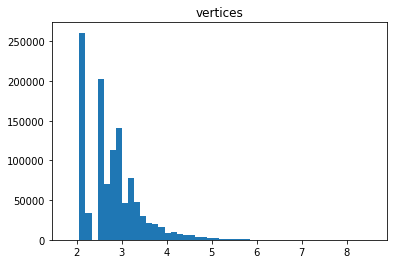

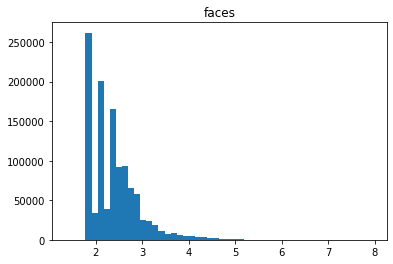

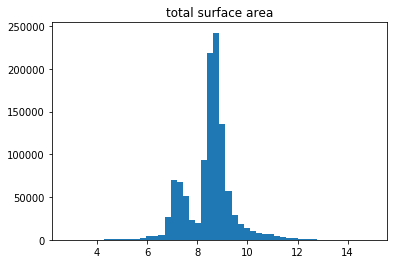

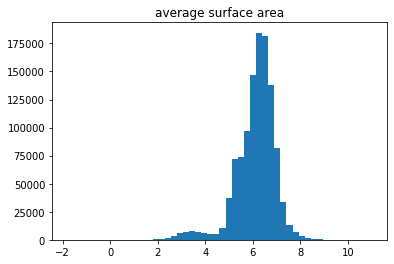

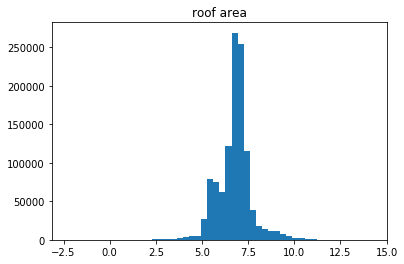

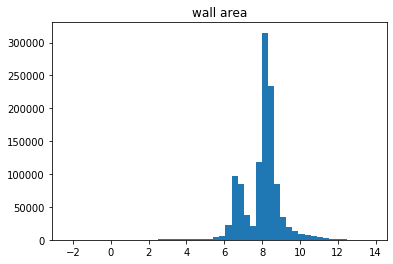

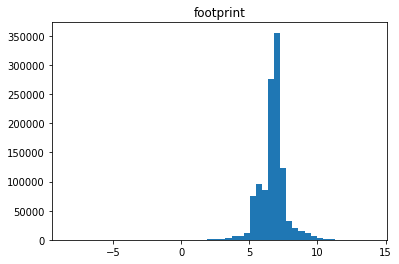

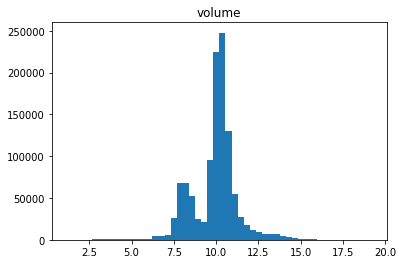

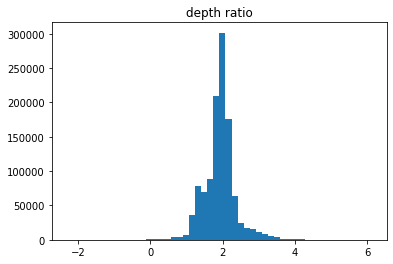

In [12]:
for idx,geometry in enumerate([vertices,faces,tsa,asa,roof,wall,footprint,volume,depth]):
    plt.hist(np.log(geometry),bins=50)
    plt.title(['vertices','faces','total surface area','average surface area','roof area','wall area','footprint','volume','depth ratio'][idx])
    plt.show()

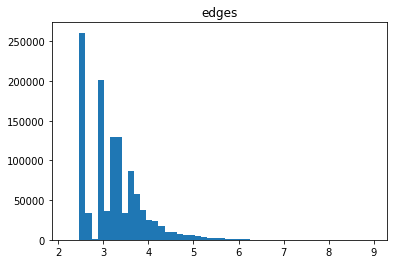

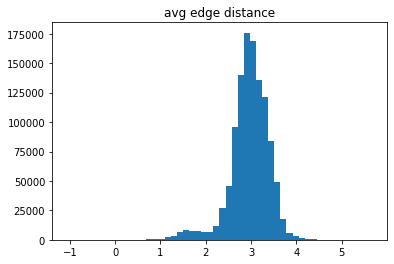

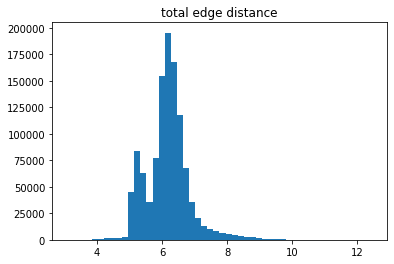

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in log
  
/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/function_base.py:780: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/function_base.py:781: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


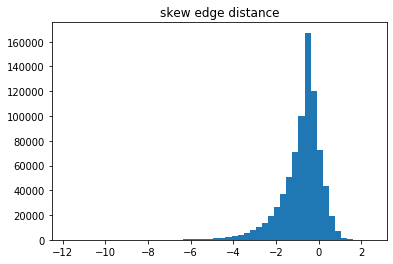

In [13]:
for idx,geometry in enumerate([edges,aed,ted,sed]):
    plt.hist(np.log(geometry),bins=50)
    plt.title(['edges','avg edge distance','total edge distance','skew edge distance'][idx])
    plt.show()

In [14]:
geodf = pd.DataFrame.from_dict(geometries,orient='index')
print(len(geodf))
geodf = geodf.merge(pd.DataFrame.from_dict(face_geo,orient='index'),left_index=True,right_index=True)
print(len(geodf))
geodf = geodf.merge(pd.DataFrame.from_dict(edge_geo,orient='index'),left_index=True,right_index=True)
print(len(geodf))
geodf.head()

1135403
1135403
1135403


,geo_x,vertices,faces,total surface area,average surface area,roof area,wall area,footprint,volume,depth ratio,geo_y,walls,roofs,geo,edges,avg edge distance,total edge distance,skew edge distance
0-0,manhattan,30,18,22045.506080,1224.750338,2272.123764,17501.258551,2272.123764,174631.714646,9.978238,manhattan,15,2,manhattan,48,34.013233,1632.635170,0.693788
0-1,manhattan,20,13,9121.801385,701.677030,1498.037450,6125.726485,1498.037450,56571.944476,9.235140,manhattan,10,2,manhattan,33,23.096252,762.176324,0.495853
0-2,manhattan,26,15,24617.626811,1641.175121,3624.680728,17368.265355,3624.680728,254526.935968,14.654713,manhattan,13,1,manhattan,39,35.606053,1388.636082,0.251678
0-3,manhattan,50,30,40625.537698,1354.184590,5880.825280,28863.887138,5880.825280,540837.899737,18.737528,manhattan,25,4,manhattan,84,34.360982,2886.322522,0.864935
0-4,manhattan,8,6,7514.329655,1252.388276,902.536528,5709.256599,902.536528,38639.393824,6.767850,manhattan,4,1,manhattan,12,36.496743,437.960912,-0.625332


In [15]:
geodf.drop(columns=['geo_x','geo_y'],inplace=True)
geodf['depth ratio'] = depth
for col in geodf.columns:
    if geodf[col].dtype == 'float':
        geodf[col] = geodf[col].round(2)
geodf.head()

,vertices,faces,total surface area,average surface area,roof area,wall area,footprint,volume,depth ratio,walls,roofs,geo,edges,avg edge distance,total edge distance,skew edge distance
0-0,30,18,22045.51,1224.75,2272.12,17501.26,2272.12,174631.71,9.98,15,2,manhattan,48,34.01,1632.64,0.69
0-1,20,13,9121.80,701.68,1498.04,6125.73,1498.04,56571.94,9.24,10,2,manhattan,33,23.10,762.18,0.50
0-2,26,15,24617.63,1641.18,3624.68,17368.27,3624.68,254526.94,14.65,13,1,manhattan,39,35.61,1388.64,0.25
0-3,50,30,40625.54,1354.18,5880.83,28863.89,5880.83,540837.90,18.74,25,4,manhattan,84,34.36,2886.32,0.86
0-4,8,6,7514.33,1252.39,902.54,5709.26,902.54,38639.39,6.77,4,1,manhattan,12,36.50,437.96,-0.63


In [16]:
# allometry
np.log(np.average(wall))/np.log(np.average(volume))

0.7580943119933966

In [17]:
# vertices to faces ratio
# buidldings with non-rectangular components
v2f = [vertices[i]/num_walls[i] for i in range(len(vertices))]
print(np.sum([0 if i==2 else 1 for i in v2f]))
print(np.sum([0 if i==2 else 1 for i in v2f])/len(geodf))

55889
0.049223931943107424


In [18]:
# non-cuboid buidldings
np.sum([0 if i==6 else 1 for i in faces])
print(np.sum([0 if i==8 else 1 for i in vertices]))
print(np.sum([0 if i==8 else 1 for i in vertices])/len(geodf))

874348
0.7700772324892571


In [19]:
# edge distance to surface area ratio
ed2s = [ted[i]/tsa[i] for i in range(len(tsa))]
ed2v = [ted[i]/volume[i] for i in range(len(volume))]

In [20]:
geodf['v2f']=v2f
geodf['ed2s']=ed2s
geodf['ed2v']=ed2v

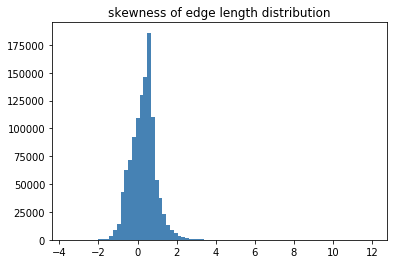

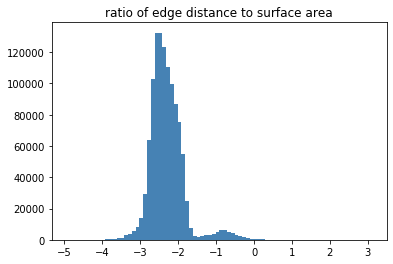

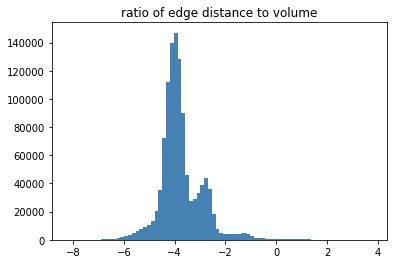

In [32]:
plt.hist(sed,bins=80,color='steelblue')
plt.title('skewness of edge length distribution')
plt.show()

for idx,geometry in enumerate([ed2s,ed2v]):
    plt.hist(np.log(geometry),bins=80,color='steelblue')
    plt.title(['ratio of edge distance to surface area',
              'ratio of edge distance to volume'][idx])
    plt.show()

In [21]:
groupdf = geodf[['geo','edges','vertices','faces','total surface area','average surface area','footprint','volume','depth ratio',
                 'total edge distance','avg edge distance','skew edge distance','v2f','ed2s','ed2v']]
groupdf = groupdf.groupby(['geo']).agg('mean').round(2)
groupdf

,edges,vertices,faces,total surface area,average surface area,footprint,volume,depth ratio,total edge distance,avg edge distance,skew edge distance,v2f,ed2s,ed2v
geo,,,,,,,,,,,,,,
bronx,36.52,23.54,14.26,11121.01,669.53,2111.66,118532.07,8.78,838.04,21.85,0.25,2.00,0.10,0.02
brooklyn,27.62,17.69,11.42,8302.48,688.10,1532.30,66686.16,7.69,624.18,23.02,0.33,1.98,0.09,0.02
manhattan,70.02,43.51,25.81,34941.46,1248.17,4332.89,607886.94,12.64,2469.09,32.72,0.55,2.00,0.08,0.01
queens,26.02,16.65,10.71,6231.68,535.12,1265.43,47713.10,7.24,515.44,19.96,0.25,2.00,0.10,0.03
staten_island,27.27,17.66,11.10,6419.39,588.62,1281.85,40785.20,7.75,542.13,21.20,0.18,2.00,0.09,0.02
zurich,104.91,66.50,37.42,1318.50,45.83,208.93,4423.56,3.56,537.45,5.91,0.87,2.59,0.49,0.40


In [33]:
basic_geometry = groupdf[['vertices','edges','faces','total edge distance','footprint','total surface area','volume']]
basic_geometry

,vertices,edges,faces,total edge distance,footprint,total surface area,volume
geo,,,,,,,
bronx,23.54,36.52,14.26,838.04,2111.66,11121.01,118532.07
brooklyn,17.69,27.62,11.42,624.18,1532.30,8302.48,66686.16
manhattan,43.51,70.02,25.81,2469.09,4332.89,34941.46,607886.94
queens,16.65,26.02,10.71,515.44,1265.43,6231.68,47713.10
staten_island,17.66,27.27,11.10,542.13,1281.85,6419.39,40785.20
zurich,66.50,104.91,37.42,537.45,208.93,1318.50,4423.56


In [34]:
complex_geometry = groupdf[['depth ratio','skew edge distance','v2f','ed2s','ed2v']]
complex_geometry

,depth ratio,skew edge distance,v2f,ed2s,ed2v
geo,,,,,
bronx,8.78,0.25,2.00,0.10,0.02
brooklyn,7.69,0.33,1.98,0.09,0.02
manhattan,12.64,0.55,2.00,0.08,0.01
queens,7.24,0.25,2.00,0.10,0.03
staten_island,7.75,0.18,2.00,0.09,0.02
zurich,3.56,0.87,2.59,0.49,0.40


In [35]:
complex_geometry.describe()

,depth ratio,skew edge distance,v2f,ed2s,ed2v
count,6.000000,6.000000,6.000000,6.000000,6.000000
mean,7.943333,0.405000,2.095000,0.158333,0.083333
std,2.917826,0.261362,0.242631,0.162655,0.155263
min,3.560000,0.180000,1.980000,0.080000,0.010000
25%,7.352500,0.250000,2.000000,0.090000,0.020000
50%,7.720000,0.290000,2.000000,0.095000,0.020000
75%,8.522500,0.495000,2.000000,0.100000,0.027500
max,12.640000,0.870000,2.590000,0.490000,0.400000


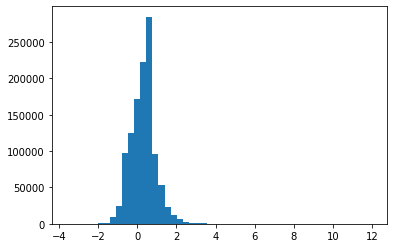

In [280]:
plt.hist(sed,bins=50)
plt.show()

In [308]:
geodf[(geodf.vertices>=8)&(geodf.faces>=6)&(geodf.footprint>0)&(geodf.walls>0)].describe().round(2)

,vertices,faces,total surface area,average surface area,roof area,wall area,footprint,volume,depth ratio,walls,roofs,edges,avg edge distance,total edge distance,skew edge distance,v2f,ed2s,ed2v,size
count,1135353.00,1135353.00,1135353.00,1135353.00,1135353.00,1135353.00,1135353.00,1.135353e+06,1135353.00,1135353.00,1135353.00,1135353.00,1135353.00,1135353.00,1135353.00,1135353.00,1135353.00,1135353.00,1135353.00
mean,21.09,13.13,8243.84,605.05,1554.87,5190.24,1498.73,7.956008e+04,7.63,10.26,1.84,33.01,21.05,660.14,0.30,2.02,0.12,0.04,1.50
std,31.13,17.98,20804.26,554.18,5611.58,12681.05,5019.38,6.604094e+05,4.88,13.64,5.84,49.89,8.31,1212.97,0.64,0.19,0.12,0.18,1.12
min,8.00,6.00,16.64,0.17,0.13,5.66,0.01,3.290000e+00,0.27,4.00,1.00,12.00,0.35,21.90,-3.59,0.88,0.01,0.00,0.00
25%,10.00,7.00,3518.67,312.13,586.60,2150.39,583.42,1.303170e+04,5.60,5.00,1.00,15.00,15.83,342.80,-0.12,2.00,0.08,0.01,1.00
50%,15.00,10.00,5506.62,517.28,931.89,3573.67,928.18,2.533163e+04,7.00,7.00,1.00,24.00,19.89,482.37,0.34,2.00,0.09,0.02,2.00
75%,22.00,14.00,7345.70,766.82,1301.79,4760.16,1292.35,3.822611e+04,8.27,11.00,2.00,36.00,25.61,655.46,0.68,2.00,0.12,0.03,3.00
max,5148.00,2768.00,3117930.97,59781.07,1447312.91,971199.78,1171584.51,2.159801e+08,454.41,2574.00,1721.00,7722.00,287.53,254437.40,11.98,66.67,22.21,42.76,3.00


In [302]:
geodf.describe().round(2)

,vertices,faces,total surface area,average surface area,roof area,wall area,footprint,volume,depth ratio,walls,roofs,edges,avg edge distance,total edge distance,skew edge distance,v2f,ed2s,ed2v,size
count,1135403.00,1135403.00,1135403.00,1135403.00,1135403.00,1135403.00,1135403.00,1.135403e+06,1135403.00,1135403.00,1135403.00,1135403.00,1135403.00,1135403.00,1135403.00,1135403.00,1135403.00,1135403.00,1135403.00
mean,21.09,13.13,8243.68,605.06,1554.85,5190.13,1498.70,7.955748e+04,7.63,10.26,1.84,33.02,21.05,660.15,0.30,2.02,0.12,0.04,1.50
std,31.17,18.03,20803.83,554.19,5611.47,12680.79,5019.27,6.603950e+05,4.88,13.65,5.86,49.98,8.31,1212.98,0.64,1.36,0.12,0.18,1.12
min,6.00,4.00,16.64,0.17,0.00,0.00,0.00,3.290000e+00,0.10,0.00,0.00,9.00,0.35,21.90,-3.59,0.88,0.01,0.00,0.00
25%,10.00,7.00,3518.48,312.13,586.56,2150.10,583.37,1.303014e+04,5.60,5.00,1.00,15.00,15.83,342.80,-0.12,2.00,0.08,0.01,0.50
50%,15.00,10.00,5506.59,517.28,931.88,3573.65,928.17,2.533127e+04,7.00,7.00,1.00,24.00,19.89,482.37,0.34,2.00,0.09,0.02,1.00
75%,22.00,14.00,7345.74,766.82,1301.79,4760.14,1292.35,3.822604e+04,8.27,11.00,2.00,36.00,25.61,655.45,0.68,2.00,0.12,0.03,2.50
max,5148.00,2768.00,3117930.97,59781.07,1447312.91,971199.78,1171584.51,2.159801e+08,454.41,2574.00,1721.00,7722.00,287.53,254437.40,11.98,1440.00,22.21,42.76,3.00


In [ ]:
# prove geographic diversity, therefore good choice of zurich and nyc boroughs
# prove dataset diversity

In [296]:
size=[]
for i in range(len(geodf)):
    if volume[i]<1.303015e+04:
        size.append(0)
    elif volume[i]<2.533127e+04:
        size.append(1)
    elif volume[i]<3.822604e+04:
        size.append(2)
    else:
        size.append(3)
geodf['size']=size

In [298]:
groupSize = geodf.groupby(['size']).agg('mean').round(2)
groupSize

,vertices,faces,total surface area,average surface area,roof area,wall area,footprint,volume,depth ratio,walls,roofs,edges,avg edge distance,total edge distance,skew edge distance,v2f,ed2s,ed2v
size,,,,,,,,,,,,,,,,,,
0,18.88,11.72,1549.90,201.44,325.29,910.72,313.88,4187.01,4.25,8.34,2.31,29.10,12.97,259.64,0.20,2.10,0.20,0.12
1,15.39,10.12,4723.24,529.05,817.58,3094.85,810.82,20094.52,6.55,7.67,1.44,24.14,21.03,452.68,0.21,1.99,0.10,0.02
2,17.64,11.29,6370.65,655.98,1122.08,4134.79,1113.78,31078.94,7.61,8.85,1.43,27.61,22.98,558.67,0.31,1.99,0.09,0.02
3,32.44,19.39,20330.93,1033.78,3954.45,12620.17,3756.32,262869.29,12.09,16.18,2.17,51.22,27.23,1369.60,0.50,2.00,0.08,0.01
